In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product b.csv', parse_dates=['Month-Year'])


In [3]:
sales_b= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [4]:
sales_b = sales_b.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_b.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,494357,2738080,177316
1,2019-02-01,837207,4637013,300290
2,2019-03-01,1278271,7079920,458491
3,2019-04-01,675985,3744057,242463
4,2019-05-01,757687,4196578,271768


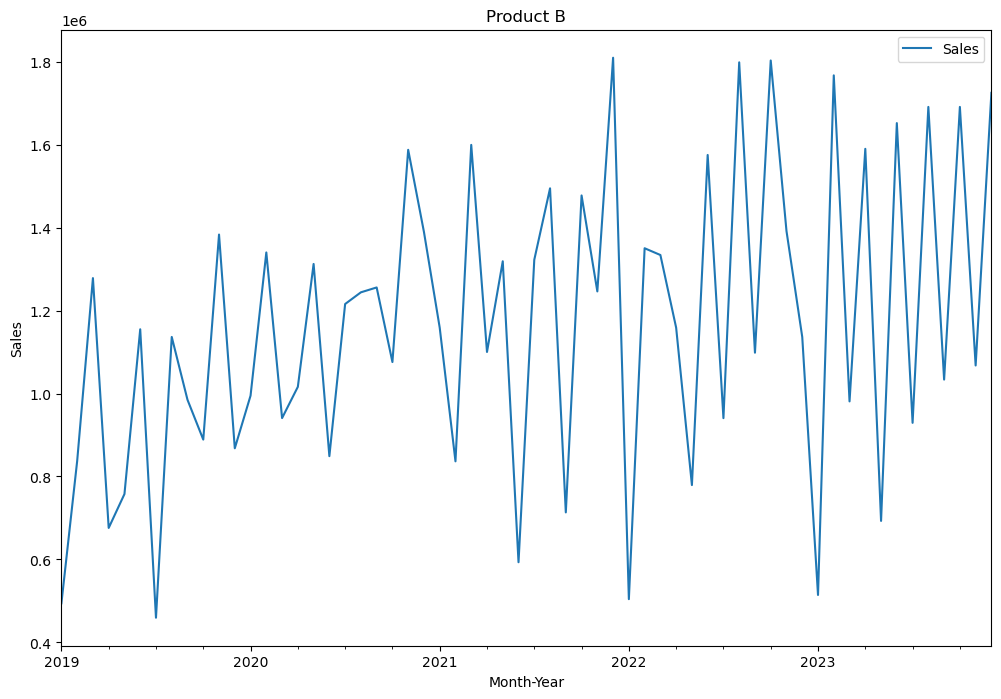

In [5]:
ax = sales_b.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product B')
plt.legend(['Sales'])
plt.show()


In [6]:
train= sales_b[:57]
test=sales_b[57:]

In [7]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='90 days', horizon = '90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

10:04:43 - cmdstanpy - INFO - Chain [1] start processing
10:04:44 - cmdstanpy - INFO - Chain [1] done processing
10:04:46 - cmdstanpy - INFO - Chain [1] start processing
10:04:47 - cmdstanpy - INFO - Chain [1] done processing
10:04:50 - cmdstanpy - INFO - Chain [1] start processing
10:04:50 - cmdstanpy - INFO - Chain [1] done processing
10:04:53 - cmdstanpy - INFO - Chain [1] start processing
10:04:53 - cmdstanpy - INFO - Chain [1] done processing
10:04:58 - cmdstanpy - INFO - Chain [1] start processing
10:04:58 - cmdstanpy - INFO - Chain [1] done processing
10:05:03 - cmdstanpy - INFO - Chain [1] start processing
10:05:03 - cmdstanpy - INFO - Chain [1] done processing
10:05:10 - cmdstanpy - INFO - Chain [1] start processing
10:05:10 - cmdstanpy - INFO - Chain [1] done processing
10:05:15 - cmdstanpy - INFO - Chain [1] start processing
10:05:15 - cmdstanpy - INFO - Chain [1] done processing
10:05:21 - cmdstanpy - INFO - Chain [1] start processing
10:05:22 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

             rmse  
0   226461.282229  
1   219634.539471  
2   236359.203425  
3   234539.914420  
4   228379.115765  
.. 

In [8]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
68,0.500,5.00,additive,144099.372271
70,0.500,10.00,additive,157036.388871
65,0.500,1.00,multiplicative,159043.037975
71,0.500,10.00,multiplicative,161850.373526
67,0.500,3.00,multiplicative,162674.319282
...,...,...,...,...
24,0.100,0.01,additive,232747.860757
3,0.001,0.10,multiplicative,234539.914420
2,0.001,0.10,additive,236359.203425
14,0.010,0.10,additive,236907.601915


In [9]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive'}


In [10]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.500, seasonality_prior_scale=5.00, seasonality_mode= 'additive', interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [11]:
model.fit(train)

10:42:38 - cmdstanpy - INFO - Chain [1] start processing
10:42:39 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
len(test)

3

In [13]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [14]:
future_dates['Market Size'] = sales_b['Market Size']
future_dates['Marketing Expense'] = sales_b['Marketing Expense']

In [15]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,2738080,177316
1,2019-02-01,4637013,300290
2,2019-03-01,7079920,458491
3,2019-04-01,3744057,242463
4,2019-05-01,4196578,271768
5,2019-06-01,6396559,414237
6,2019-07-01,2545212,164826
7,2019-08-01,6294066,407600
8,2019-09-01,5454980,353261
9,2019-10-01,4923556,318846


In [16]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [17]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

In [18]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
57,2023-10-01,1.711167e+06,1.660974e+06,1.756634e+06
58,2023-11-01,1.036973e+06,9.544834e+05,1.109650e+06
59,2023-12-01,1.726489e+06,1.599138e+06,1.847352e+06


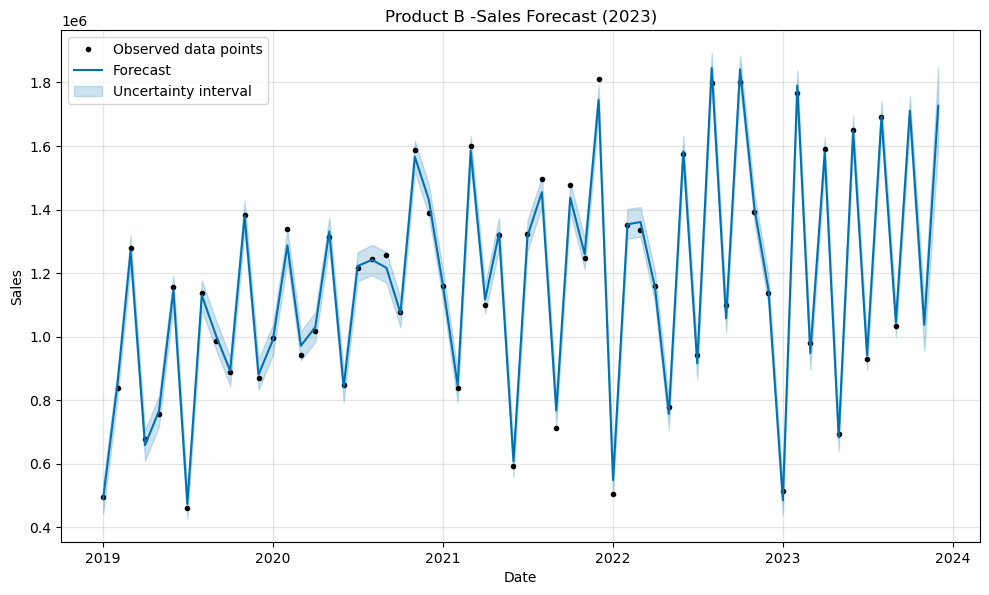

In [19]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product B -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

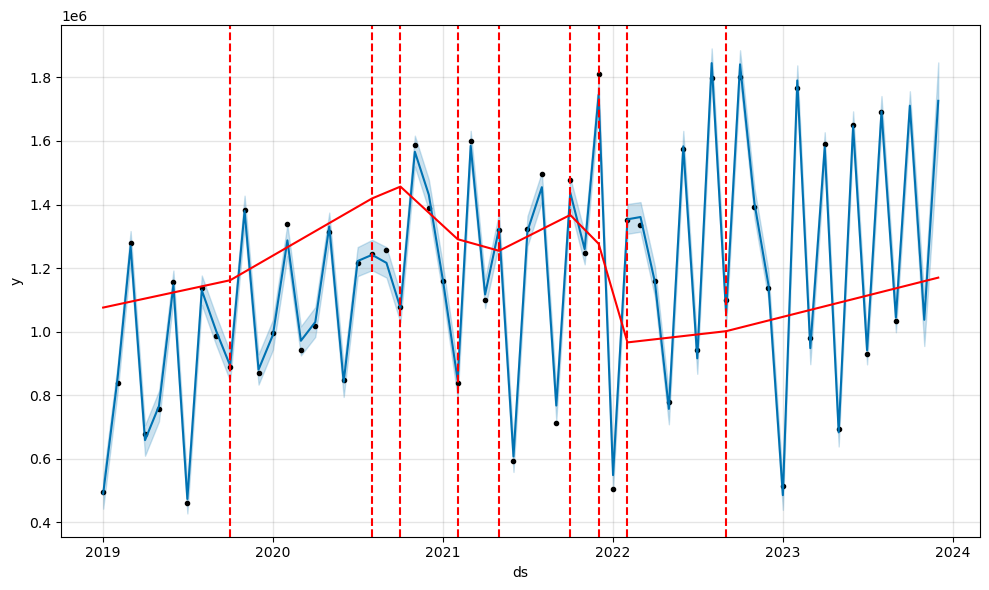

In [20]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

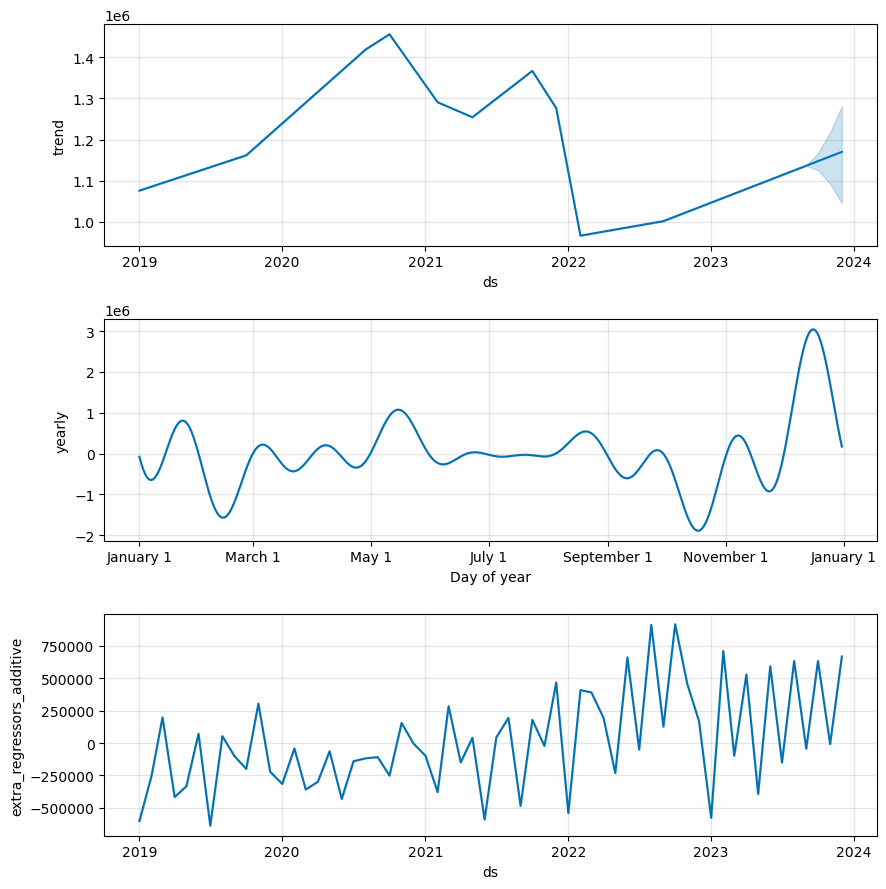

In [21]:
fig2 = model.plot_components(forecast)

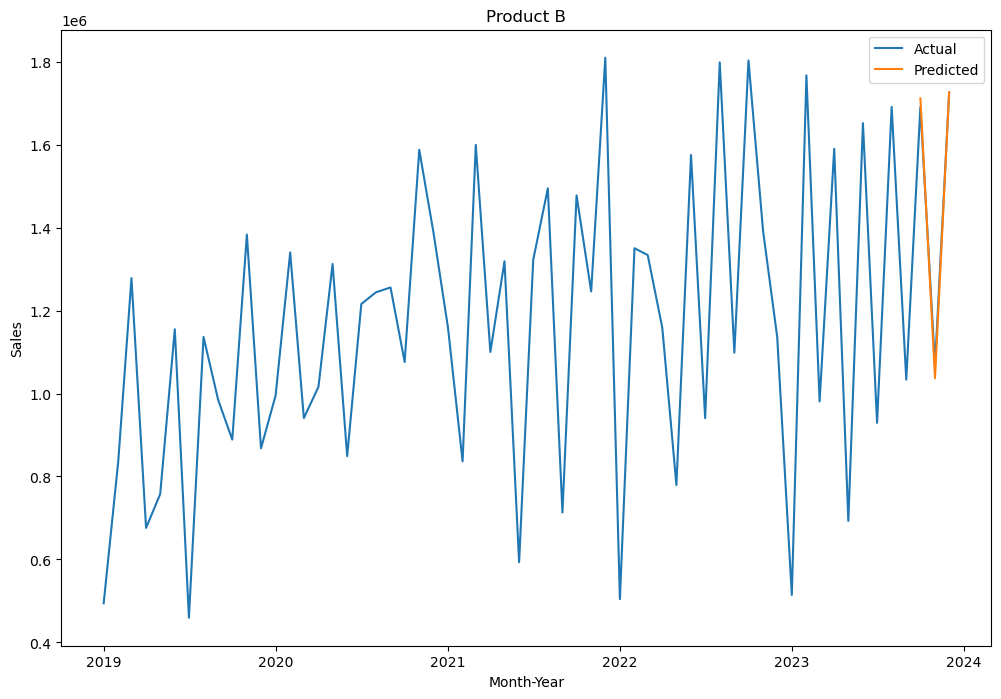

In [22]:
# Reset index of sales_b DataFrame
sales_b_reset_index = sales_b.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_b_reset_index['ds'], sales_b_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product B')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [23]:
#model evaluation

In [24]:
pred=forecasted_df['yhat']
test_df=test['y']

In [25]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 17467.461
MAPE - FB PROPHET: 0.014
MSE - FB PROPHET: 450037675.092
RMSE - FB PROPHET: 21214.091


In [26]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='90 days', horizon='90 days', parallel="processes")

In [27]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,20 days,3.818187e+08,19540.181011,17063.353925,0.012452,0.016211,0.012358,0.666667
1,22 days,7.408941e+09,86075.206658,67278.456663,0.109940,0.030155,0.098322,0.333333
2,23 days,7.217700e+09,84957.048798,59301.176142,0.104544,0.030155,0.092969,0.666667
3,25 days,4.423352e+09,66508.283326,46131.309186,0.061415,0.027418,0.055504,0.833333
4,27 days,2.321168e+10,152353.797539,108420.693981,0.180355,0.027418,0.236544,0.666667
5,28 days,2.325479e+10,152495.219763,108851.150984,0.189409,0.054580,0.245239,0.666667
6,47 days,1.210355e+10,110016.151825,66852.290998,0.106813,0.010810,0.134500,0.833333
7,49 days,9.096394e+08,30160.228787,22128.878945,0.022041,0.009037,0.021570,1.000000
8,51 days,2.812250e+08,16769.764352,13961.850931,0.010862,0.009037,0.010949,1.000000
9,52 days,6.720629e+09,81979.440997,56489.016253,0.067517,0.021042,0.073456,1.000000


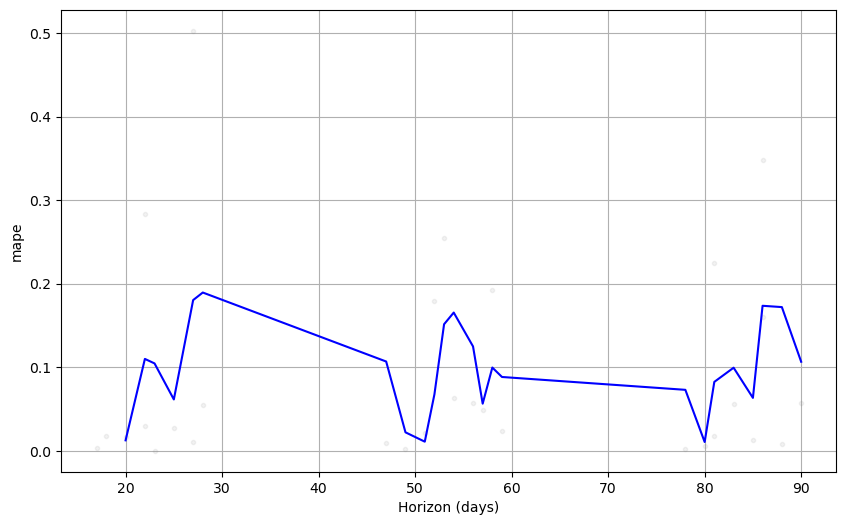

In [28]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [29]:
test_df

57    1690948
58    1067615
59    1724948
Name: y, dtype: int64

In [30]:
pred

57    1.711167e+06
58    1.036973e+06
59    1.726489e+06
Name: yhat, dtype: float64